# Ciudadano Distrito

In [50]:
import time
import subprocess
import math
                                                                                                                                    
from tqdm.notebook import tqdm

import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
import psycopg2 as psql
from sqlalchemy import create_engine
from functools import partial
import matplotlib.pyplot as plt

from networkx import is_connected, connected_components
from gerrychain import (
    Graph, updaters, Partition, constraints, MarkovChain, accept, proposals,
    tree
)
import maup

In [38]:
query_postgres = True

province_id = '30'

province_mapper = {
    '02': 'Albacete',
    '03': 'Alicante/Alacant',
    '04': 'Almería',
    '01': 'Araba/Álava',
    '33': 'Asturias',
    '05': 'Ávila',
    '06': 'Badajoz',
    '07': 'Balears, Illes',
    '08': 'Barcelona',
    '48': 'Bizkaia',
    '09': 'Burgos',
    '10': 'Cáceres',
    '11': 'Cádiz',
    '39': 'Cantabria',
    '12': 'Castellón/Castelló',
    '13': 'Ciudad Real',
    '14': 'Córdoba',
    '15': 'Coruña, A',
    '16': 'Cuenca',
    '20': 'Gipuzkoa',
    '17': 'Girona',
    '18': 'Granada',
    '19': 'Guadalajara',
    '21': 'Huelva',
    '22': 'Huesca',
    '23': 'Jaén',
    '24': 'León',
    '25': 'Lleida',
    '27': 'Lugo',
    '28': 'Madrid',
    '29': 'Málaga',
    '30': 'Murcia',
    '31': 'Navarra',
    '32': 'Ourense',
    '34': 'Palencia',
    '35': 'Palmas, Las',
    '36': 'Pontevedra',
    '26': 'Rioja, La',
    '37': 'Salamanca',
    '38': 'Santa Cruz de Tenerife',
    '40': 'Segovia',
    '41': 'Sevilla',
    '42': 'Soria',
    '43': 'Tarragona',
    '44': 'Teruel',
    '45': 'Toledo',
    '46': 'Valencia/València',
    '47': 'Valladolid',
    '49': 'Zamora',
    '50': 'Zaragoza',
    '51': 'Ceuta',
    '52': 'Melilla'
}

In [39]:
psql_config = {
    'database': 'geoblink_gamma',
    'user': 'geoblink',
    'password': 'Geo_S4urio',
    'host': 'datanalytics',
    'port': '5441'
}

if query_postgres:
    conn = psql.connect(**psql_config)

In [4]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'province'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    province = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    province = gpd.read_parquet('data/province.parquet')

province.head()

,id_area,name,pob_t_total,geometry
0,30,Murcia,1493898.0,"MULTIPOLYGON (((-1.54669 37.40733, -1.54845 37..."


In [5]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'municipality'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    municipality = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    municipality = gpd.read_parquet('data/municipality.parquet')

municipality.head()

,id_area,name,pob_t_total,geometry
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37..."
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38..."
3,30027,Molina de Segura,71890.0,"MULTIPOLYGON (((-1.17779 38.01970, -1.17918 38..."
4,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38..."


In [6]:
municipality.to_parquet('data/municipality.parquet')

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [7]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'district'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    district = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    district = gpd.read_parquet('data/district.parquet')

district.head()

,id_area,name,pob_t_total,geometry
0,3090201,3090201,16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85195 37..."
1,3090101,3090101,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
2,3004301,3004301,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11950 38..."
3,3004201,3004201,2910.0,"MULTIPOLYGON (((-1.31083 38.12816, -1.31010 38..."
4,3004106,3004106,997.0,"MULTIPOLYGON (((-0.87233 37.60224, -0.84062 37..."


In [8]:
district.to_parquet('data/district.parquet')

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [9]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'zip_code'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    zip_code = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    zip_code = gpd.read_parquet('data/zip_code.parquet')
zip_code.head()

,id_area,name,pob_t_total,geometry
0,30001,30001,6672.558439,"MULTIPOLYGON (((-1.12543 37.98749, -1.12644 37..."
1,30002,30002,20612.835950,"MULTIPOLYGON (((-1.12798 37.98225, -1.12794 37..."
2,30004,30004,8536.843875,"MULTIPOLYGON (((-1.13204 37.98721, -1.13192 37..."
3,30003,30003,11593.958973,"MULTIPOLYGON (((-1.12372 37.98900, -1.12363 37..."
4,30008,30008,13816.797284,"MULTIPOLYGON (((-1.13190 37.99662, -1.13178 37..."


In [10]:
zip_code.to_parquet('data/zip_code.parquet')

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [11]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'census_section'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""


if query_postgres:
    census_section = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    census_section = gpd.read_parquet('data/census_section.parquet')
    
census_section.head()

,id_area,name,pob_t_total,geometry
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38..."
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38..."
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37..."
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38..."
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38..."


In [12]:
census_section.to_parquet('data/census_section.parquet')

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


## Find optimal aggregation

In [13]:
# Obtain province codes
province['province_id'] = province['id_area']
province_ids = province['province_id'].tolist()

municipality['province_id'] = municipality['id_area'].str[:2]
# municipality['latitude'] = municipality['geometry'].centroid.y
# municipality['longitude'] = municipality['geometry'].centroid.x

district['province_id'] = district['id_area'].str[:2]
# district['latitude'] = district['geometry'].centroid.y
# district['longitude'] = district['geometry'].centroid.x

zip_code['province_id'] = zip_code['id_area'].str[:2]
# zip_code['latitude'] = zip_code['geometry'].centroid.y
# zip_code['longitude'] = zip_code['geometry'].centroid.x

census_section['province_id'] = census_section['id_area'].str[:2]
# census_section['latitude'] = census_section['geometry'].centroid.y
# census_section['longitude'] = census_section['geometry'].centroid.x

In [14]:
query = f"province_id == '{province_id}'"

In [15]:
province_cp = province.query(query).copy()
municipality_cp = municipality.query(query).copy()
district_cp = district.query(query).copy()
zip_code_cp = zip_code.query(query).copy()
census_section_cp = census_section.query(query).copy()

geo_data = {
    'province': province_cp, 
    'municipality': municipality_cp,
    'district': district_cp,
    'zip_code': zip_code_cp,
    'census_section': census_section_cp
}

KeplerGl(height=800, width=1000).save_to_html(geo_data, file_name='province.html', center_map=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to province.html!


In [16]:
target = 35000
variable = "pob_t_total"
node_repeats = 1

In [17]:
areas = municipality.copy()

province_area = areas.query(query)
mask = province_area[variable] < target

gdf_area = province_area[mask].copy()
gdf_area.head()

,id_area,name,pob_t_total,geometry,province_id
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37...",30
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38...",30
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38...",30
4,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38...",30
5,30042,Villanueva del Río Segura,2910.0,"MULTIPOLYGON (((-1.30946 38.12814, -1.30936 38...",30


In [18]:
# Municipalities with more than target population
filtered_out = province_area[~mask].copy()
filtered_out.head()

,id_area,name,pob_t_total,geometry,province_id
3,30027,Molina de Segura,71890.0,"MULTIPOLYGON (((-1.17779 38.01970, -1.17918 38...",30
11,30037,Torre-Pacheco,35676.0,"MULTIPOLYGON (((-0.93699 37.72427, -0.93751 37...",30
19,30030,Murcia,453258.0,"MULTIPOLYGON (((-1.05083 37.72357, -1.05337 37...",30
23,30024,Lorca,94404.0,"MULTIPOLYGON (((-1.44785 37.58778, -1.44660 37...",30
27,30016,Cartagena,214802.0,"MULTIPOLYGON (((-0.71421 37.61790, -0.71487 37...",30


In [19]:
# Obtain a more granular level to fill in the gaps created by the municipalities that did not satisfy the target
filtered_census_section = census_section.query(query).copy()
filtered_census_section.head()

,id_area,name,pob_t_total,geometry,province_id
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38...",30
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38...",30
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37...",30
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38...",30
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38...",30


/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/gerrychain/graph/graph.py:228: UserWarning: Found islands (degree-0 nodes). Indices of islands: {37, 13, 6}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)
/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/gerrychain/graph/graph.py:152: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


<AxesSubplot:>

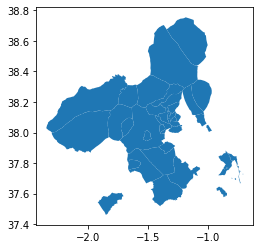

In [20]:
Graph.from_geodataframe(gdf_area)
gdf_area.plot()

<AxesSubplot:>

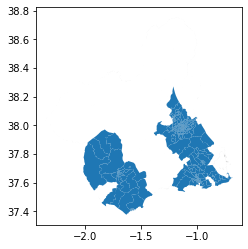

In [21]:
filtered_out = filtered_out[['name', 'geometry']]
difference = gpd.overlay(filtered_census_section, gdf_area, how='difference', keep_geom_type=False)

# Filter out from zip_code
#Graph.from_geodataframe(difference)
difference.plot()

<AxesSubplot:>

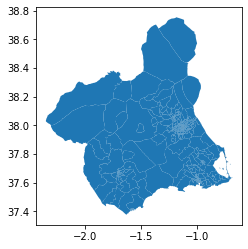

In [22]:
gdf = gpd.GeoDataFrame(pd.concat([gdf_area, difference], ignore_index=True))
gdf.plot()

In [23]:
# gdf['geometry'] = maup.close_gaps(gdf['geometry'])
# gdf.head()

# gdf['geometry'] = maup.resolve_overlaps(gdf['geometry'], relative_threshold=0.5)
# gdf.head()

In [24]:
graph = Graph.from_geodataframe(gdf)
graph.add_data(gdf)

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(11, 177), (176, 752), (29, 424), (21, 507), (19, 816), (22, 507), (33, 464), (361, 578), (24, 805), (4, 462), (34, 478), (23, 387), (33, 691), (10, 635), (22, 936), (36, 771), (0, 932), (10, 794), (9, 933), (10, 343), (33, 866), (6, 361), (25, 926), (11, 638), (79, 436), (30, 578), (31, 517), (37, 597), (30, 478), (404, 936), (32, 387), (27, 694), (539, 694), (10, 485), (9, 635), (6, 359), (22, 761), (31, 285), (4, 712), (333, 653), (18, 920), (30, 361), (24, 176), (22, 560), (337, 479), (19, 386), (1, 147), (7, 464), (21, 772), (32, 560), (33, 608), (21, 376), (406, 693), (648, 868), (9, 97), (27, 539), (714, 868), (5, 422), (8, 406), (14, 722), (28, 457), (8, 714), (9, 810), (13, 38), (539, 561), (11, 347), (11, 750), (6, 86), (17, 908), (18, 479), (9, 88), (545, 810), (697, 738), (33, 799), (13, 57

In [25]:
myupdaters = {
    "population": updaters.Tally(variable, alias="population"),
    "cut_edges": updaters.cut_edges,
}

47.50377527173913


<AxesSubplot:>

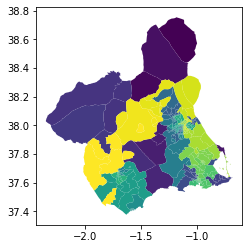

In [26]:
total_population = sum([graph.nodes[n][variable] for n in graph.nodes])
districts = total_population / target
print(districts)

assignment = tree.recursive_tree_part(
    graph, 
    range(int(round(districts))),
    target, #ideal population for a district
    variable,
    0.2
)

#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)
initial_partition.plot(gdf) #you have to hand it gdf, the geodataframe for the graph

In [27]:
province_area.head()

,id_area,name,pob_t_total,geometry,province_id
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37...",30
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38...",30
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38...",30
3,30027,Molina de Segura,71890.0,"MULTIPOLYGON (((-1.17779 38.01970, -1.17918 38...",30
4,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38...",30


In [28]:
mapper = {graph.nodes[node]['id_area']: node for node in graph.nodes}
gdf['district'] = gdf['id_area'].apply(lambda x: assignment.get(mapper.get(x)))
display(gdf.groupby('district')[variable].sum().describe())

districts = gdf.dissolve(by='district', aggfunc='sum').reset_index().copy()


kepler = KeplerGl(height=800, width=1000)

province_area_cp = province_area.copy()
kepler.add_data(data=province_area_cp, name='municipality')

districts_cp = districts.copy()
kepler.add_data(data=districts_cp, name='district')

gdf_cp = gdf.copy()
kepler.add_data(data=gdf_cp, name='municipalites-censussection')


kepler

count       48.000000
mean     34638.169469
std       4423.305058
min      17510.000000
25%      31798.188692
50%      34664.000000
75%      37627.250000
max      42195.000000
Name: pob_t_total, dtype: float64

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'municipality': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [29]:
#no need for contiguity since that is forced by the proposal
myconstraints = [
    constraints.contiguous, #fast contiguity tracker only for flip walks
    constraints.within_percent_of_ideal_population(initial_partition, 0.5) #population deviation
]

#little python trick to fix some parameters in the proposal function
myproposal = partial(
    proposals.recom,
    pop_col=variable,
    pop_target=target,
    epsilon=0.2, #population tolerance
    node_repeats=2 #parameter for spanning tree method, set to 2 is fine
)

In [30]:

# Configure the MarkovChain.

chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [31]:
for i, step in enumerate(chain):
    print(i, end=" ")
    gdf['flipstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [32]:
gdf.head()

,id_area,name,pob_t_total,geometry,province_id,district,flipstep0,flipstep1,flipstep2,flipstep3,...,flipstep990,flipstep991,flipstep992,flipstep993,flipstep994,flipstep995,flipstep996,flipstep997,flipstep998,flipstep999
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37...",30,12,12,12,12,12,...,26,26,26,26,26,26,26,26,26,26
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38...",30,44,44,44,44,44,...,31,31,14,14,14,14,14,14,14,14
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38...",30,7,7,7,7,7,...,29,29,29,29,29,29,29,29,29,29
3,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38...",30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30042,Villanueva del Río Segura,2910.0,"MULTIPOLYGON (((-1.30946 38.12814, -1.30936 38...",30,45,45,45,45,45,...,1,1,1,1,1,1,1,1,1,1


In [33]:
number = 9
column = f'flipstep{number}'

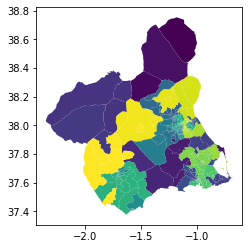

In [34]:
gdf.plot(column=column.format(number))
plt.show()

In [75]:
table_name = 'district_murcia'
engine = create_engine('postgres://{user}:{password}@{host}:{port}/{database}'.format(**psql_config))
gdf.to_postgis(table_name, con=engine)

In [78]:
gdf.head()

,id_area,name,pob_t_total,geometry,province_id,district,flipstep0,flipstep1,flipstep2,flipstep3,...,flipstep990,flipstep991,flipstep992,flipstep993,flipstep994,flipstep995,flipstep996,flipstep997,flipstep998,flipstep999
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37...",30,12,12,12,12,12,...,26,26,26,26,26,26,26,26,26,26
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38...",30,44,44,44,44,44,...,31,31,14,14,14,14,14,14,14,14
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38...",30,7,7,7,7,7,...,29,29,29,29,29,29,29,29,29,29
3,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38...",30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30042,Villanueva del Río Segura,2910.0,"MULTIPOLYGON (((-1.30946 38.12814, -1.30936 38...",30,45,45,45,45,45,...,1,1,1,1,1,1,1,1,1,1


In [79]:
def linestring_to_points(feature,line):
    return {feature:line.coords}

gdf.apply(lambda l: linestring_to_points(l['id_area'],l['geometry']), axis=1)

NotImplementedError: ('Multi-part geometries do not provide a coordinate sequence', 'occurred at index 0')

In [76]:
query = f"""
    SELECT
        {column},
        ST_CollectionExtract(ST_Union(ST_MakeValid(geometry)), 3),
        SUM(pob_t_total)
    FROM
        {table_name}
    GROUP BY
        {column}
"""

table = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')

# Delete table
cur = conn.cursor()
cur.execute(f'DROP TABLE IF EXISTS {table_name};')
conn.commit()
cur.close()

table.head()

DatabaseError: Execution failed on sql '
    SELECT
        flipstep9,
        ST_CollectionExtract(ST_Union(ST_MakeValid(geometry)), 3),
        SUM(pob_t_total)
    FROM
        district_murcia
    GROUP BY
        flipstep9
': GEOSUnaryUnion: TopologyException: found non-noded intersection between LINESTRING (-1.31727 38.2404, -1.30164 38.2511) and LINESTRING (-1.31823 38.2397, -1.31675 38.2407) at -1.3168908070461409 38.240621694005981


In [35]:
# gdf['geometry'] = gdf['geometry'].buffer(0.0001)
districts = gdf.dissolve(by=column, aggfunc='sum').reset_index().copy()
districts.head()

,flipstep9,geometry,pob_t_total,district,flipstep0,flipstep1,flipstep2,flipstep3,flipstep4,flipstep5,...,flipstep990,flipstep991,flipstep992,flipstep993,flipstep994,flipstep995,flipstep996,flipstep997,flipstep998,flipstep999
0,0,"POLYGON ((-1.11967 38.73772, -1.11677 38.73240...",34432.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"MULTIPOLYGON (((-1.47480 38.11524, -1.47480 38...",37076.0,3,3,3,3,3,3,3,...,47,47,47,47,47,47,47,47,47,47
2,2,"MULTIPOLYGON (((-1.06836 38.44972, -1.06836 38...",28156.0,4,4,4,4,4,4,4,...,51,51,51,51,51,51,51,51,51,51
3,3,"MULTIPOLYGON (((-0.75083 37.79337, -0.75048 37...",33141.0,15,15,15,15,15,15,15,...,169,169,169,169,169,169,169,169,169,169
4,4,"MULTIPOLYGON (((-1.22531 37.57421, -1.22502 37...",34944.0,260,260,260,52,52,52,52,...,311,311,311,311,311,284,284,284,284,284


In [37]:
kepler = KeplerGl(height=800, width=1000)

districts_cp = districts.copy()
kepler.add_data(data=districts_cp, name='districts')

gdf_cp = gdf.copy()
kepler.add_data(data=gdf_cp, name='municipalites-censussection')

kepler

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'districts': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…